<a href="https://colab.research.google.com/github/ahaditi/TSF-Internship-tasks/blob/main/Data_Science_%26_Business_Analytics_TSF_Task_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt  #Altair is a declarative statistical visualization library for Python

import statsmodels.api as sm 

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

In [ ]:

!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.2 MB/s 
     |████████████████████████████████| 9.9 MB 48.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
df_prices = pd.read_csv('/content/sample_data/TCS.NS.csv')
print(df_prices.head())
print(df_prices.size)

         Date         Open         High          Low        Close  \
0  2021-12-16  3582.000000  3608.449951  3570.000000  3581.600098   
1  2021-12-17  3602.500000  3651.350098  3573.699951  3584.350098   
2  2021-12-20  3589.000000  3606.000000  3510.149902  3556.899902   
3  2021-12-21  3582.649902  3641.199951  3566.399902  3608.300049   
4  2021-12-22  3624.000000  3636.800049  3606.250000  3630.750000   

     Adj Close   Volume  
0  3532.902344  2072320  
1  3535.614990  4333992  
2  3508.537842  2312310  
3  3559.239258  2340989  
4  3581.383789  1224328  
1750


In [ ]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       250 non-null    datetime64[ns]
 1   Open       250 non-null    float64       
 2   High       250 non-null    float64       
 3   Low        250 non-null    float64       
 4   Close      250 non-null    float64       
 5   Adj Close  250 non-null    float64       
 6   Volume     250 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 13.8 KB


In [ ]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

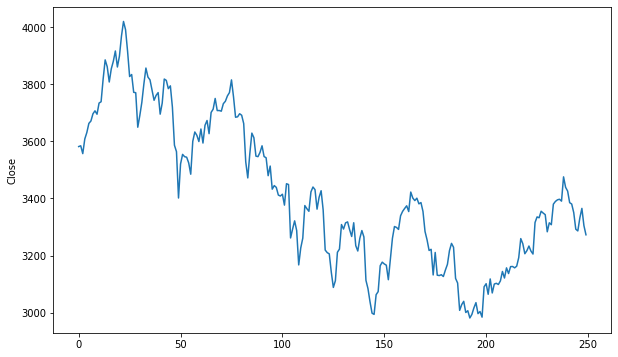

In [ ]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

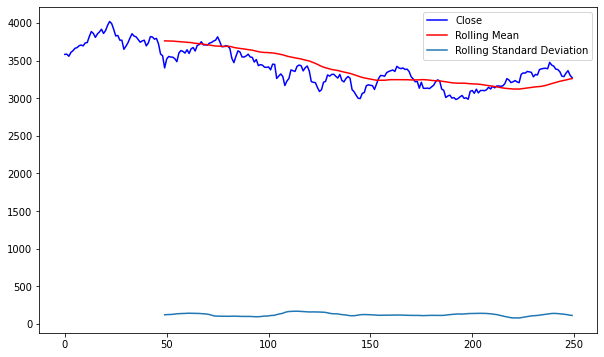

In [ ]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

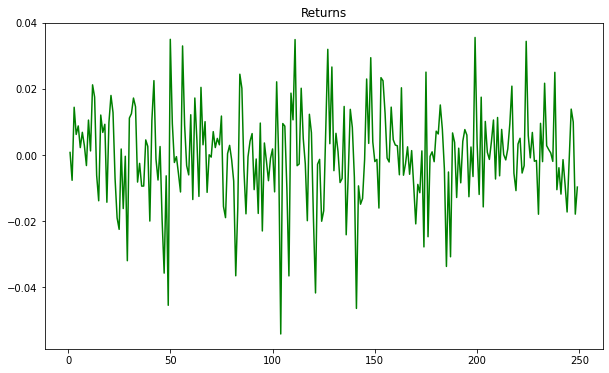

In [ ]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [ ]:
train = df_prices[:1000]
test = df_prices[1000:]

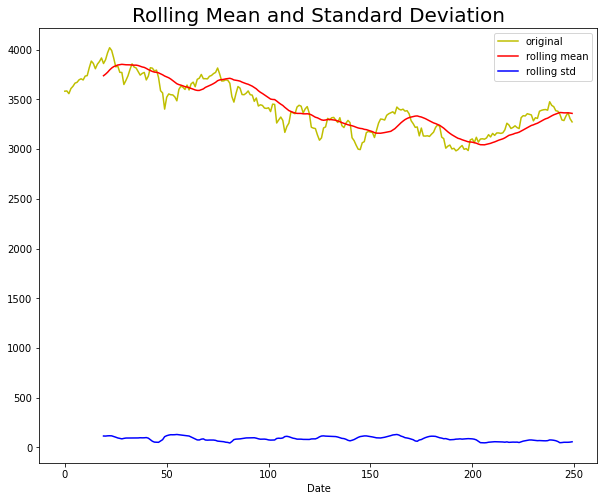

Results of dickey fuller test
ADF Test Statistic : -1.5592914953511094
p-value : 0.5040037672005543
#Lags Used : 0
Number of Observations Used : 249
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

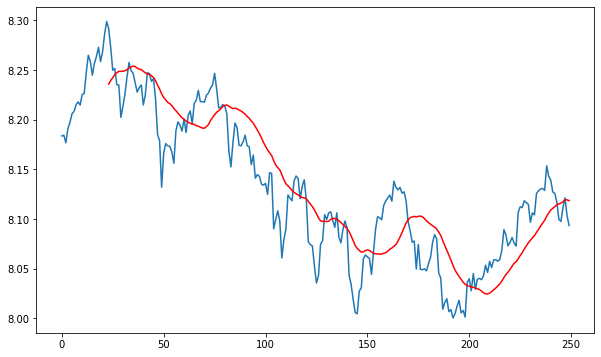

In [ ]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

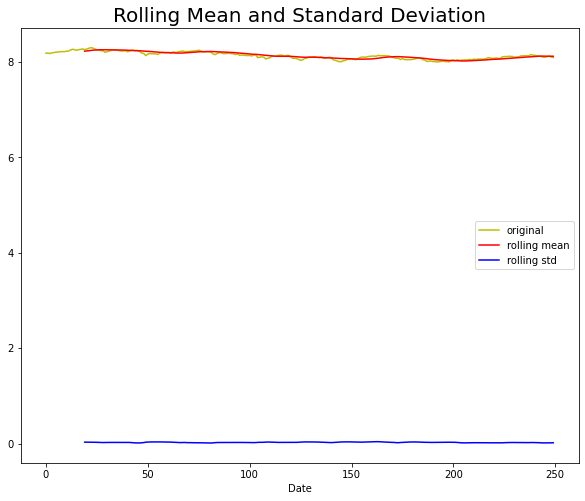

Results of dickey fuller test
ADF Test Statistic : -1.5869237933944425
p-value : 0.49015873280014827
#Lags Used : 0
Number of Observations Used : 249
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

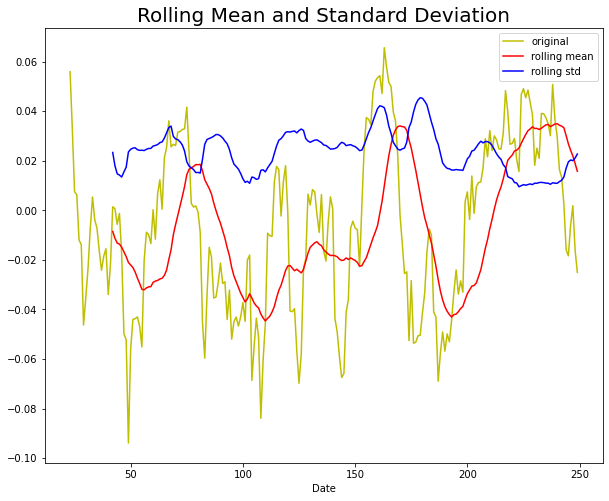

Results of dickey fuller test
ADF Test Statistic : -3.600774831115774
p-value : 0.0057462319093709935
#Lags Used : 0
Number of Observations Used : 226
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [ ]:

train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [ ]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1383.267, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1390.926, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1389.119, Time=0.88 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1389.129, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1392.775, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1386.957, Time=0.78 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.403 seconds


ValueError: ignored

NameError: ignored

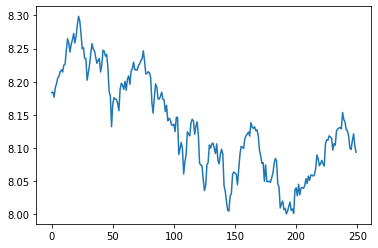

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')